In [2]:
# this will be the main script for the finalized project

from load_scheduler import *
from import_setup import *
from modules.electrolyzer import *
from modules.methanation import *
from init import *


# TODO: in the future, these variables can also be handled by a separate function/script
# for easier handling, different dataframes are created for the most needed quantities
# for type safety, the variables extracted from df are all specified as float arrays
# variables that are written into a new line every timestep
time_arr = df["Time / h"].values.astype(float)
time_diff = df["Time_diff / h"].values.astype(float)
raw_price = df["Price / EURO/MWh"].values.astype(float)
# gas_production = df["Gas Production / Nm^3/h"].values.astype(float)
# heat_demand_fermenter = df["Fermenter Heat Demand / kW"].values.astype(float)
# chp_run_time = np.ones((time_arr.shape[0], num_chps))
# chp_load = np.zeros((time_arr.shape[0], num_chps))
# chp_el_power = np.zeros((time_arr.shape[0], num_chps))
# chp_th_power = np.zeros((time_arr.shape[0], num_chps))
# chp_gas_consumption = np.zeros((time_arr.shape[0], num_chps))
maintenance = np.zeros((time_arr.shape[0], num_chps))
# maintenance_time_per_rule = np.zeros((time_arr.shape[0], num_chps, num_maintenance_rules))
gas_storage = np.zeros(time_arr.shape)
gas_storage_tendency = np.zeros(time_arr.shape)
# flare_run_time = np.zeros(time_arr.shape[0])
# flare_gas_consumption = np.zeros(time_arr.shape[0])
temp_heat_net = np.zeros(time_arr.shape[0])
# boiler_load = np.zeros((time_arr.shape[0], num_boilers))
# boiler_th_power = np.zeros((time_arr.shape[0], num_boilers))
# boiler_run_time = np.zeros((time_arr.shape[0], num_boilers))
# boiler_gas_consumption = np.zeros((time_arr.shape[0], num_boilers))

# variables that are overwritten every timestep
run_time_between_maintenance = np.zeros(
    [num_chps, chp_maintenance_rules.shape[1]], dtype=float)
maintenance_remaining_failure = np.zeros(num_chps, dtype=float)


# initialize operator

operator = LoadScheduler(flare_threshold, chp_gas_storage_rules,
                         chp_maintenance_rules, chps, boilers, electrolyzer, heat_net, price_threshold=80)
gas_storage[0] = 2402.79  # Nm^3
gas_storage_tendency[0] = 1  # Nm^3/h
temp_heat_net[0] = 70  # °C


logging.debug("Starting simulation")
# Start the stopwatch
tic = time.time()

for k in range(1, len(time_arr)):
    # old_run_time=np.array([1,1]), old_maintenance=np.array([0,0]), old_gas_storage=1200, new_time_diff=1, new_price=0.1
    # run scheduler
    logging.debug("now calculating timestep: " + str(k))

    # calculate new temperature of heat network based on heat demand of fermenter
    temp_heat_net[k] = heat_net.new_temperature(
        fermenter.heat_demand[0], temp_heat_net[k - 1], mass_flow_heat_net)
    # schedule runnning of chps and flare (and boilers)
    (
        maintenance[k, :],
        _,
        _,
        _,
        _,
        run_time_between_maintenance,
    ) = operator.schedule_production(
        maintenance[k - 1, :],
        gas_storage[k - 1],
        gas_storage_tendency[k - 1],
        time_diff[k],
        raw_price[k],
        maintenance_remaining_failure,
        temp_heat_net[k],
        mass_flow_heat_net,
        80,
    )
    # run CHPs
    for i in range(num_chps):
        maintenance_remaining_failure[i] = chps[i].run(run_time_between_maintenance[i, :], 
                                                       maintenance_remaining_failure[i], 
                                                       time_diff[k], 
                                                       biogas.h_u)
    # run flare
    flare.run()

    # run Boilers
    for i in range(num_boilers):
        boilers[i].th_power[k], boilers[i].gas_consumption[k] = boilers[i].run(biogas.h_u)

    # calculate new temperature of heat network based on heat demand of fermenter
    temp_heat_net[k] = heat_net.new_temperature(np.sum([boilers[i].th_power[k] for i in range(num_boilers)]) \
     + np.sum([chps[i].th_power[k] for i in range(chp_count)]), temp_heat_net[k - 1], mass_flow_heat_net)

    # calculate new gas storage.
    # TODO: For now, the gas storage can be computed in main. If future complexity is coming in (if some costs are associated with it etc...) the gas storage needs to be separated into another object
    # in Nm^3
    gas_storage[k] = gas_storage[k - 1] + (fermenter.gas_production[k] - np.sum([chps[i].gas_consumption[k] for i in range(chp_count)]) - flare.gas_consumption[k]) * time_diff[k]
    gas_storage_tendency[k] = gas_storage[k] - gas_storage[k - 1]

    # every 1000 timesteps, print the current timestep as info log level
    if k % 10000 == 0:
        logging.info("timestep: " + str(k) + " of " + str(len(time_arr)))

    # For debugging, print a timestep near the problem to stop sim there
    if time_arr[k] == 7100 * 3:
        logging.debug("timestep: " + str(k) + " of " + str(len(time_arr)))

# Stop the stopwatch
toc = time.time()

logging.info("Simulation took {:3.2f}s to compute, with {} steps".format(
    toc - tic, len(time_arr)))




ModuleNotFoundError: No module named 'load_scheduler'

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot gas storage with sns
sns.lineplot(x=time_arr, y=gas_storage.storage)
plt.show()


NameError: name 'time_arr' is not defined

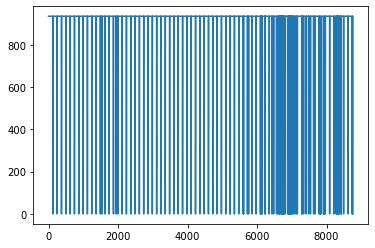

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot gas storage with sns
sns.lineplot(x=time_arr, y=chps[1].th_power)
plt.show()


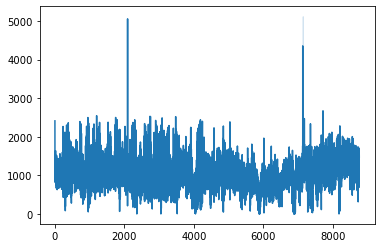

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot gas storage with sns
sns.lineplot(x=time_arr, y=flare.gas_consumption)
plt.show()

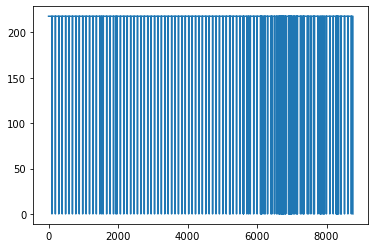

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot gas storage with sns
sns.lineplot(x=time_arr, y=chps[3].gas_consumption)
plt.show()

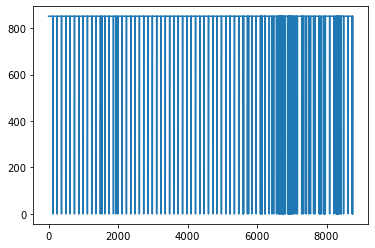

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot gas storage with sns
sns.lineplot(x=time_arr, y=chps[1].el_power)
plt.show()